## DSCI100 Project - Exploring Player Behaviors in Minecraft and their Contribution to the Game

#### Jazmine Eleanor Cabaluna | DSCI 100-003


In [123]:
#loading tidyverse, tidymodels, and repr libraries
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

In [124]:
#loading and preliminary examination of provided players and sesssions dataset
players<-read_csv("players.csv")
sessions<-read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [125]:
# players
# sessions

In [126]:

playerdemog<-players|>
    select(played_hours, Age, gender)|>
    mutate(log_hours=log(1+played_hours))|> #log hours for better plotting and visualization
    na.omit()
playerdemog

played_hours,Age,gender,log_hours
<dbl>,<dbl>,<chr>,<dbl>
30.3,9,Male,3.44361810
3.8,17,Male,1.56861592
0.0,17,Male,0.00000000
0.7,21,Female,0.53062825
0.1,21,Male,0.09531018
⋮,⋮,⋮,⋮
0.0,20,Male,0.0000000
0.0,17,Female,0.0000000
0.3,22,Male,0.2623643


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


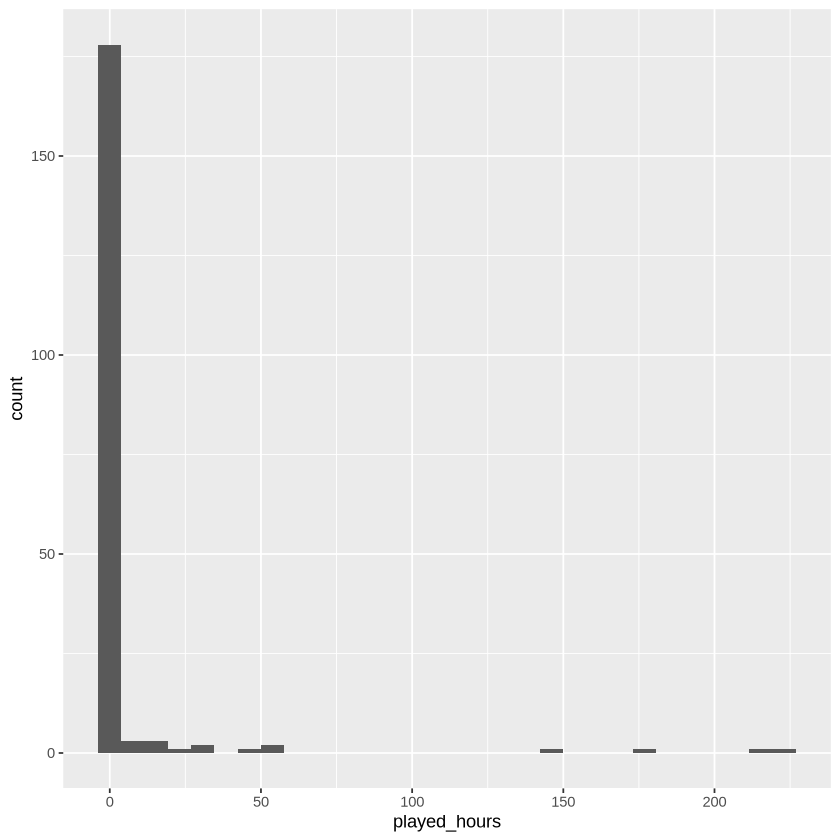

In [127]:
#histogram distribution of played_hours
hours<-playerdemog|>
    ggplot(aes(x=played_hours))+
    geom_histogram()
hours

Warning message:
“Removed 36 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


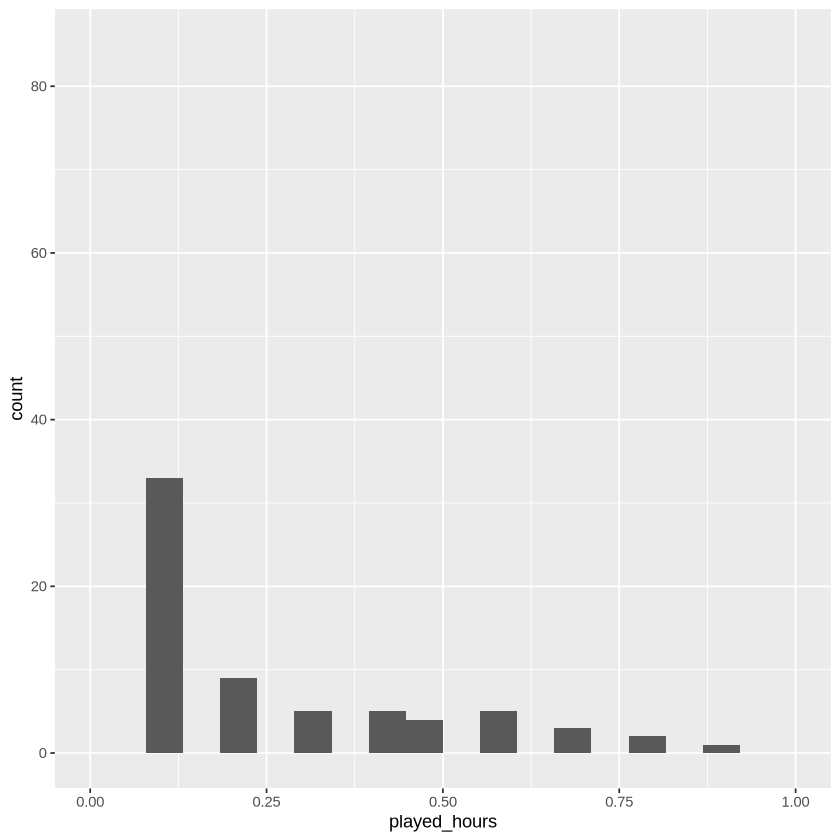

In [128]:
zoomed_hours<-playerdemog|>
    ggplot(aes(x=played_hours))+
    geom_histogram(bins=20)+
    xlim(0,1)
zoomed_hours

In [129]:
#finding the median played_hours and using that as the basis for our practical definition of "time frame which gives the largest amount of data"
hours<-playerdemog|>
summarize(med_hours = median(played_hours))
hours

med_hours
<dbl>
0.1


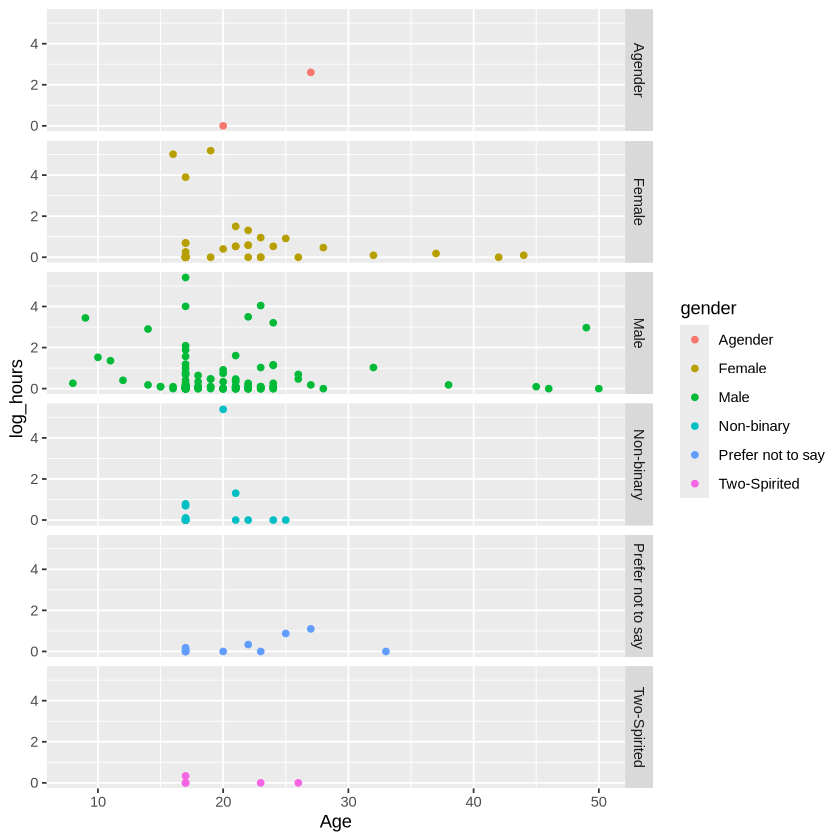

In [130]:
ageplot<-playerdemog|>
    ggplot(aes(x=Age, y=log_hours,color=gender))+
    geom_point()+
    facet_grid(rows=vars(gender))
    

ageplot



In [131]:
#forming main player data dataset with all relevant predictors
player_main<-playerdemog|>
    select(played_hours:gender)
player_main

played_hours,Age,gender
<dbl>,<dbl>,<chr>
30.3,9,Male
3.8,17,Male
0.0,17,Male
0.7,21,Female
0.1,21,Male
⋮,⋮,⋮
0.0,20,Male
0.0,17,Female
0.3,22,Male


In [132]:
#using KNN regression to determine how much a player of a certain gender and age 
#will be doing a 5 fold cross validation on the data set TO DETERMINE THE BEST K
#data should be split into training and testing

#split data into training and testing data sets, 60:40 in training:testing 
split<-initial_split(player_main, prop=0.6, strata=played_hours)
player_training<-training(split)
player_testing<-testing(split)

#forming a recipe 
hour_recipe<-recipe(played_hours ~., data=player_training)|>  #using all predictors in the dataset
    step_scale(all_numeric())|> #only scaling the numeric data (age)
    step_center(all_numeric()) 

#forming a tuning model to determine best k
tune_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("regression") #doing a regression algorithm

#5-fold cross-validation
#folds are created in a random way, so re-running this code would result in slight differences in prediction estimates
vfold<-vfold_cv(player_training, v=5, strata=played_hours)

#setting a range of k=1-10 to find the best k
kvals<-tibble(neighbors=seq(from=1, to=10, by=1))

#developing a fit
tune_fit<-workflow()|>
    add_recipe(hour_recipe)|>
    add_model(tune_spec)

#collecting data to find the smallest RMSE
kvals_result<-tune_fit|>
    tune_grid(resamples=vfold, grid=kvals)|>
    collect_metrics()|>
    filter(.metric=="rmse") #error occurs here
kvals_result



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,1.0917960,5,0.4448395,Preprocessor1_Model01
2,rmse,standard,1.1310676,5,0.3437010,Preprocessor1_Model02
3,rmse,standard,1.0399083,5,0.3577953,Preprocessor1_Model03
4,rmse,standard,1.0154695,5,0.3567445,Preprocessor1_Model04
5,rmse,standard,0.9883267,5,0.3664360,Preprocessor1_Model05
6,rmse,standard,1.0016865,5,0.3602013,Preprocessor1_Model06
7,rmse,standard,1.0114979,5,0.3549411,Preprocessor1_Model07
8,rmse,standard,1.0086197,5,0.3516346,Preprocessor1_Model08
9,rmse,standard,1.0141831,5,0.3521696,Preprocessor1_Model09


In [133]:
# finding k value with minimum rmse for use in testing model
kvals_min<-kvals_result|>
   slice_min(mean, n=1)|>#finds the row with the minimum mean
    pull(neighbors)
kvals_min

[1] 5

In [136]:
player_testing

played_hours,Age,gender
<dbl>,<dbl>,<chr>
3.8,17,Male
0.0,17,Male
0.1,21,Male
0.1,17,Male
1.6,23,Female
⋮,⋮,⋮
0.1,18,Male
0.0,17,Male
0.0,17,Male


In [137]:
#Assess RMSPE on testing data
#Using same recipe, hour_recipe

#Must make new model using the testing data
kmin_spec<-nearest_neighbor(weight_func="rectangular", neighbors=kvals_min)|>
    set_engine("kknn")|>
    set_mode("regression")

kmin_fit<-workflow()|>
    add_recipe(hour_recipe)|>
    add_model(kmin_spec)|>
    fit(data=player_testing) #fitting onto the testing data

#forming predictions on testing data


In [138]:
hour_summary<-fit|>
    predict(player_testing)|>
    bind_cols(player_testing)|>
    metrics(truth=played_hours, estimate=.pred)|>
    filter(.metric=="rmse")
hour_summary

ERROR: Error in UseMethod("predict"): no applicable method for 'predict' applied to an object of class "function"


No documentation for ‘function.’ in specified packages and libraries:
you could try ‘??function.’